In [4]:
def choose_data_from_dict(mode:str)-> dict:
    path = 'after_processed_data_file\\dict_data_'+mode+'_for_analy_fix_birth.json'
    dict_ = json.load(open(path,'r'))
    new_dict = {}
    for eid,dict__ in dict_.items():
        static = dict__['log_features'][:8]
        infomation = dict__['info_features']
        label = dict__['label']

        new_dict[eid] = {}
        new_dict[eid]['static'] = static
        new_dict[eid]['infomation'] = infomation
        new_dict[eid]['label'] = label

    return new_dict
def assemble_transfor_matrix_and_others(matrix_dict,others_dict)-> dict:
    if len(matrix_dict)!=len(others_dict):print('Error length mismatch.')
    else:
        new_dict = {}
        for eid in others_dict.keys():

            new_dict[eid] = {}
            new_dict[eid]['features'] = [
                                    *others_dict[eid]['static'] ,
                                    *others_dict[eid]['infomation'] ,
                                    *matrix_dict[int(eid)] ]
            new_dict[eid]['label'] = others_dict[eid]['label']

        return new_dict
def prepare_label(dict_data)-> list:
    """
        dict_data : { e_id: {
                            'log_features':[] ,
                            'info_features':[] ,
                            'label' : 1 or 0
                            } 
                    }

    Returns:
        list_assemble_data : [[ *log_features , *info_features ],......]
        list_e_id : [ e_id_1 ,e_id_2,...... ]
        list_label : [ 0, 1, ..........]
    """    
    list_assemble_data = []
    list_e_id = []
    list_label = []
    for e_id,dict_ in dict_data.items():

        log_data  = dict_['features']

        label     = dict_['label']

        list_assemble_data.append(log_data)
        list_e_id.append(int(e_id))
        list_label.append(int(label))

    return list_assemble_data , list_e_id , list_label
def nomilized_matrix(dict_matrix,matrix_type: str,ignore=False)-> dict:
    import numpy as np
    if matrix_type =='complex':
        for eid,dict_ in dict_matrix.items():
            matrix_= dict_['features'][18:]
            sum_ = np.sum(matrix_)
            if (sum_ != 0):
                for i in range(18,502):
                    dict_matrix[eid]['features'][i] =int(30000*dict_matrix[eid]['features'][i]/sum_)
        return dict_matrix
    if matrix_type =='simple':
        new_dict = {}
        for eid,dict_ in dict_matrix.items():
            if ignore ==False:    
                matrix_= dict_['log_features'][8:]           
                sum_ = np.sum(matrix_)
                if sum_ != 0:
                    for i in range(8,24):
                        try:
                            dict_matrix[eid]['log_features'][i] =int(1000*dict_matrix[eid]['log_features'][i]/sum_)
                        except:
                            print(dict_matrix[eid]['log_features'][i],sum_)
                        
                    
            new_dict[eid]={}
            new_dict[eid]['features'] = [
                *dict_matrix[eid]['info_features'],
                *dict_matrix[eid]['log_features']
                ]
           
            new_dict[eid]['label'] = dict_matrix[eid]['label']

        return new_dict
def predict_label_to_int(predict_label_list,threshold):

    predict_label_int = []
    for i in predict_label_list:
        value= i
        if value >threshold:label_ = int(1)
        else:label_ = int(0)
        predict_label_int.append(label_)

    return predict_label_int

def measure(predict_label_int,list_label_test):
    f1             = f1_score(predict_label_int,list_label_test)
    accuracy = accuracy_score(predict_label_int,list_label_test)
   # AUC =       roc_auc_score(predict_label_int,list_label_test)
    precision = precision_score(predict_label_int,list_label_test)
    recall = recall_score(predict_label_int,list_label_test)

    print(
        'F1',round(f1,4),
        'precision',round(precision,2),
        'recall',round(recall,2),
        'ACC',round(accuracy,2),
        )
def plot_AUC(ori_label,predict_label):
    import pylab as plt
    import warnings;warnings.filterwarnings('ignore')
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(ori_label, predict_label)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
def xgb_model(train_data,test_data)->list:
    dtrain = xgb.DMatrix(train_data, list_label_train)
    dtest = xgb.DMatrix(test_data,list_label_test)
    num_rounds = 10
    params = {}
    watchlist = [(dtrain,'train'),(dtest,'test')]
    XGB_nom = xgb.train(
        params, 
        dtrain, 
        num_rounds,
        watchlist,
        early_stopping_rounds=10) 
        
    #import pickle
    #pickle.dump(XGB_nom, open("XGB_simple_no_nom_f1_9015.pickle.dat", "wb"))

    XGB_predict_label = XGB_nom.predict(dtest)
    plot_AUC(list_label_test,XGB_predict_label)
    for i in [0.1,0.2,0.3,0.4,0.5,0.6]:
            
        XGB_predict_label_int = predict_label_to_int(XGB_predict_label,threshold=i)
        #print('XGB ',i,' : ')
        measure(
                XGB_predict_label_int,list_label_test)
    
    return XGB_nom

def lr_model(train_data_padding,test_data_padding)->list:
    lr = linear_model.LinearRegression(
        normalize=True
        ,n_jobs=-1)
    lr.fit(train_data_padding, list_label_train)
    result = lr.predict(test_data_padding)

    plot_AUC(list_label_test,result)

    for i in [0.001, 0.499,0.5,0.501 ]:
    #for i in [0.5 ]:
        predict_LinearRegression = predict_label_to_int(
            result,
            threshold= i)
        #print('LR ',i,' : ')
        measure(
            predict_LinearRegression,list_label_test)

    return lr

def assemble_predicted_and_predict_label(
    list_label,
    list_e_id,
    predict_label,
    mode='eid')-> dict:
    """
    Returns:
        dict: { e_id:[ predicted_label , predict_label ]}
    """    
    if mode =='eid': 
        dict_ori_and_predict_label = {}
        for row in range(len(list_label)):
            e_id = list_e_id[row]
            ori_label = list_label[row]
            dict_ori_and_predict_label[e_id] = [ori_label,predict_label[row]]

        return dict_ori_and_predict_label
    if mode =='TorF':
        dict_ ={
                'TP':[],
                'TN':[],
                'FP':[],
                'FN':[]
            }
        
        for i in range(len(list_e_id)):
            eid = list_e_id[i]
            ori = list_label[i]
            pre = predict_label[i]
            
            if pre==ori: # SUCCESS
                if ori ==1:
                    dict_['TP'].append(eid)
                if ori ==0:
                    dict_['TN'].append(eid)
            else:        # Fail
                if pre ==1:
                    dict_['FP'].append(eid)
                if pre ==0:
                    dict_['FN'].append(eid)
        return dict_



In [5]:
# Simple matrix
dict_train_simple_matrix = json.load(open('after_processed_data_file\\dict_data_train_for_analy_fix_birth.json','r'))
dict_test_simple_matrix  = json.load(open('after_processed_data_file\\dict_data_test_for_analy_fix_birth.json','r'))


dict_train_simple_nom = nomilized_matrix(
    dict_train_simple_matrix,
    matrix_type = 'simple',
    ignore=True)
dict_test_simple_nom = nomilized_matrix(
    dict_test_simple_matrix,
    matrix_type = 'simple',
    ignore= True)

list_data_train_simple,list_e_id_train,list_label_train = prepare_label(dict_train_simple_nom)
list_data_test_simple,list_e_id_test,list_label_test    = prepare_label(dict_test_simple_nom)
'''
new_ = []
for i in range(len(list_data_test_simple)):
    new_.append([*list_data_test_simple[i],list_label_train[i]])
import pandas as pd 
pd.DataFrame(new_).to_csv('list_data_train_simple_with_label.csv')
'''
train_data_simple =np.array( list_data_train_simple)
test_data_simple  =np.array( list_data_test_simple)

 
Padding = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_data_simple_padding = Padding.fit_transform(train_data_simple)
test_data_simple_padding  = Padding.fit_transform(test_data_simple)

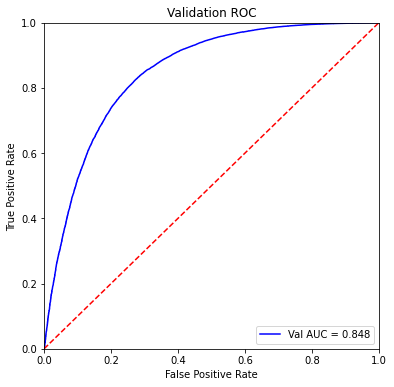

F1 0.8699 precision 1.0 recall 0.77 ACC 0.77
F1 0.9005 precision 0.95 recall 0.86 ACC 0.84
F1 0.9005 precision 0.95 recall 0.86 ACC 0.84
F1 0.9005 precision 0.95 recall 0.86 ACC 0.84
[0]	train-rmse:0.41888	test-rmse:0.42797
[1]	train-rmse:0.37127	test-rmse:0.38808
[2]	train-rmse:0.34489	test-rmse:0.36620
[3]	train-rmse:0.32987	test-rmse:0.35563
[4]	train-rmse:0.32153	test-rmse:0.34995
[5]	train-rmse:0.31686	test-rmse:0.34732
[6]	train-rmse:0.31402	test-rmse:0.34570
[7]	train-rmse:0.31216	test-rmse:0.34545
[8]	train-rmse:0.31087	test-rmse:0.34531
[9]	train-rmse:0.30986	test-rmse:0.34504


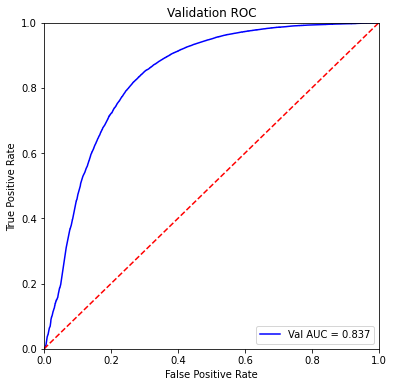

F1 0.8782 precision 0.99 recall 0.79 ACC 0.79
F1 0.89 precision 0.99 recall 0.81 ACC 0.81
F1 0.8965 precision 0.98 recall 0.83 ACC 0.83
F1 0.9012 precision 0.96 recall 0.85 ACC 0.84
F1 0.8998 precision 0.94 recall 0.86 ACC 0.84
F1 0.8936 precision 0.91 recall 0.88 ACC 0.84


In [6]:

poly = PolynomialFeatures(degree=2) #degree=2表示二次多项式
train_poly = poly.fit_transform(train_data_simple_padding) #构造datasets_X二次多项式特征X_poly
test_poly = poly.fit_transform(test_data_simple_padding) #构造datasets_X二次多项式特征X_poly


LR_PLOY_2=lr_model(train_poly,test_poly)

XGB_POLY_2=xgb_model(train_poly,test_poly)


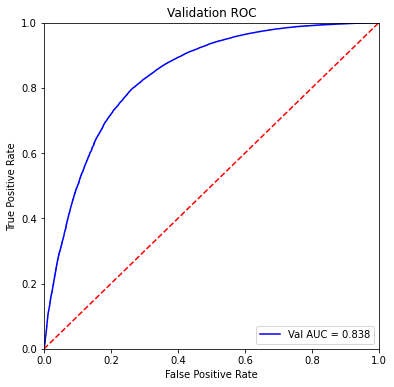

F1 0.8659 precision 1.0 recall 0.76 ACC 0.77
F1 0.8947 precision 0.96 recall 0.84 ACC 0.83
F1 0.8948 precision 0.96 recall 0.84 ACC 0.83
F1 0.8949 precision 0.96 recall 0.84 ACC 0.83
[0]	train-rmse:0.42142	test-rmse:0.42822
[1]	train-rmse:0.37437	test-rmse:0.38769
[2]	train-rmse:0.34744	test-rmse:0.36633
[3]	train-rmse:0.33239	test-rmse:0.35531
[4]	train-rmse:0.32400	test-rmse:0.34950
[5]	train-rmse:0.31928	test-rmse:0.34679
[6]	train-rmse:0.31658	test-rmse:0.34545
[7]	train-rmse:0.31452	test-rmse:0.34537
[8]	train-rmse:0.31333	test-rmse:0.34495
[9]	train-rmse:0.31263	test-rmse:0.34476


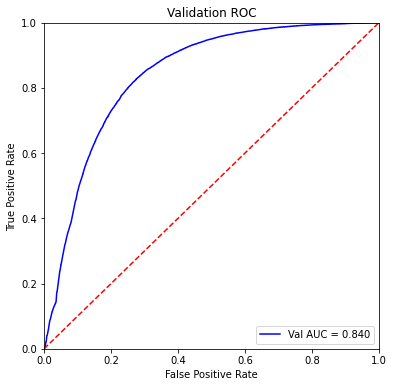

F1 0.8767 precision 1.0 recall 0.78 ACC 0.79
F1 0.8889 precision 0.99 recall 0.81 ACC 0.81
F1 0.8961 precision 0.98 recall 0.83 ACC 0.83
F1 0.9004 precision 0.96 recall 0.85 ACC 0.84
F1 0.8997 precision 0.94 recall 0.86 ACC 0.84
F1 0.8926 precision 0.91 recall 0.88 ACC 0.83


In [7]:


LR=lr_model(train_data_simple_padding,test_data_simple_padding)

XGB=xgb_model(train_data_simple_padding,test_data_simple_padding)

In [10]:
LR.coef_

array([-0.01581294, -0.00156297,  0.00197693,  0.00084767,  0.        ,
       -0.        ,  0.00001669,  0.00132215,  0.00592057,  0.00455295,
       -0.00000112,  0.        , -0.11395419,  0.00821684, -0.00160117,
        0.00000624, -0.01118685,  0.0001889 , -0.00000831, -0.03674878,
       -0.07507315, -0.01117312,  0.0364724 , -0.0000212 , -0.01785446,
        0.01920073,  0.04129181, -0.02400207,  0.0003601 ,  0.04595042,
        0.01125374, -0.02016872, -0.0523411 , -0.00102402])

In [15]:
coef = pd.DataFrame(LR.coef_,index = col)

In [16]:
coef

,0
gender,-1.581294e-02
birth_year,-1.562972e-03
edu_degree,1.976927e-03
course_category,8.476715e-04
course_type,1.160627e-12
course_duration,-1.007410e-09
student_amount,1.669001e-05
course_amount,1.322153e-03
dropout_rate_of_course,5.920573e-03
dropout_rate_of_user,4.552948e-03


In [19]:
coef = pd.DataFrame(LR.coef_,index = col).sort_values(0)

In [20]:
coef

,0
L_skew,-1.139542e-01
13,-7.507315e-02
43,-5.234110e-02
12,-3.674878e-02
32,-2.400207e-02
42,-2.016872e-02
23,-1.785446e-02
gender,-1.581294e-02
S_skew,-1.118685e-02
14,-1.117312e-02


<AxesSubplot:>

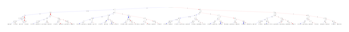

In [27]:
fig.set_size_inches(60,30)
plot_tree(XGB,fmap='', num_trees=0, rankdir='UT', ax=None)



[0]	train-rmse:0.42142	test-rmse:0.42822
[1]	train-rmse:0.37437	test-rmse:0.38769
[2]	train-rmse:0.34744	test-rmse:0.36633
[3]	train-rmse:0.33239	test-rmse:0.35531
[4]	train-rmse:0.32400	test-rmse:0.34950
[5]	train-rmse:0.31928	test-rmse:0.34679
[6]	train-rmse:0.31658	test-rmse:0.34545
[7]	train-rmse:0.31452	test-rmse:0.34537
[8]	train-rmse:0.31333	test-rmse:0.34495
[9]	train-rmse:0.31263	test-rmse:0.34476


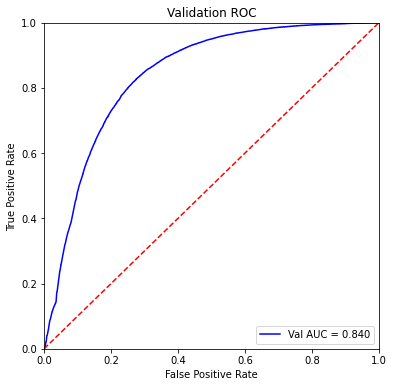

F1 0.8767 precision 1.0 recall 0.78 ACC 0.79
F1 0.8889 precision 0.99 recall 0.81 ACC 0.81
F1 0.8961 precision 0.98 recall 0.83 ACC 0.83
F1 0.9004 precision 0.96 recall 0.85 ACC 0.84
F1 0.8997 precision 0.94 recall 0.86 ACC 0.84
F1 0.8926 precision 0.91 recall 0.88 ACC 0.83


In [28]:

XGB_df=xgb_model(pd.DataFrame(train_data_simple_padding,columns = col),pd.DataFrame(test_data_simple_padding,columns = col))

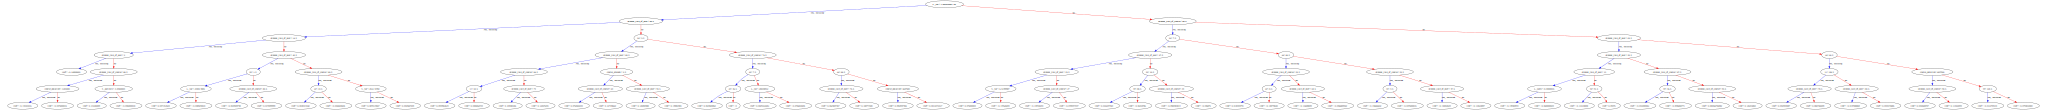

In [29]:
import xgboost as xgb
xgb.to_graphviz(XGB_df)

In [30]:
def xgb_model_depth_3(train_data,test_data)->list:
    dtrain = xgb.DMatrix(train_data, list_label_train)
    dtest = xgb.DMatrix(test_data,list_label_test)
    num_rounds = 10
    params = {'max_depth':3}
    watchlist = [(dtrain,'train'),(dtest,'test')]
    XGB_nom = xgb.train(
        
        params, 
        dtrain, 
        num_rounds,
        watchlist,
        early_stopping_rounds=10) 
        
    #import pickle
    #pickle.dump(XGB_nom, open("XGB_simple_no_nom_f1_9015.pickle.dat", "wb"))

    XGB_predict_label = XGB_nom.predict(dtest)
    plot_AUC(list_label_test,XGB_predict_label)
    for i in [0.1,0.2,0.3,0.4,0.5,0.6]:
            
        XGB_predict_label_int = predict_label_to_int(XGB_predict_label,threshold=i)
        #print('XGB ',i,' : ')
        measure(
                XGB_predict_label_int,list_label_test)
    
    return XGB_nom

[0]	train-rmse:0.42906	test-rmse:0.43296
[1]	train-rmse:0.38625	test-rmse:0.39373
[2]	train-rmse:0.36134	test-rmse:0.37335
[3]	train-rmse:0.34690	test-rmse:0.36056
[4]	train-rmse:0.33822	test-rmse:0.35443
[5]	train-rmse:0.33317	test-rmse:0.35052
[6]	train-rmse:0.32857	test-rmse:0.34867
[7]	train-rmse:0.32669	test-rmse:0.34771
[8]	train-rmse:0.32487	test-rmse:0.34737
[9]	train-rmse:0.32354	test-rmse:0.34750


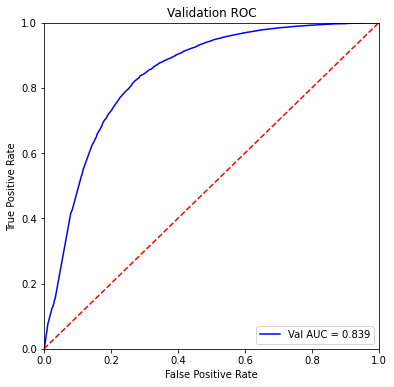

F1 0.8722 precision 1.0 recall 0.77 ACC 0.78
F1 0.8842 precision 0.99 recall 0.8 ACC 0.8
F1 0.8921 precision 0.98 recall 0.82 ACC 0.82
F1 0.897 precision 0.97 recall 0.83 ACC 0.83
F1 0.898 precision 0.94 recall 0.86 ACC 0.84
F1 0.8917 precision 0.91 recall 0.87 ACC 0.83


In [31]:

XGB_df_md3=xgb_model_depth_3(pd.DataFrame(train_data_simple_padding,columns = col),pd.DataFrame(test_data_simple_padding,columns = col))


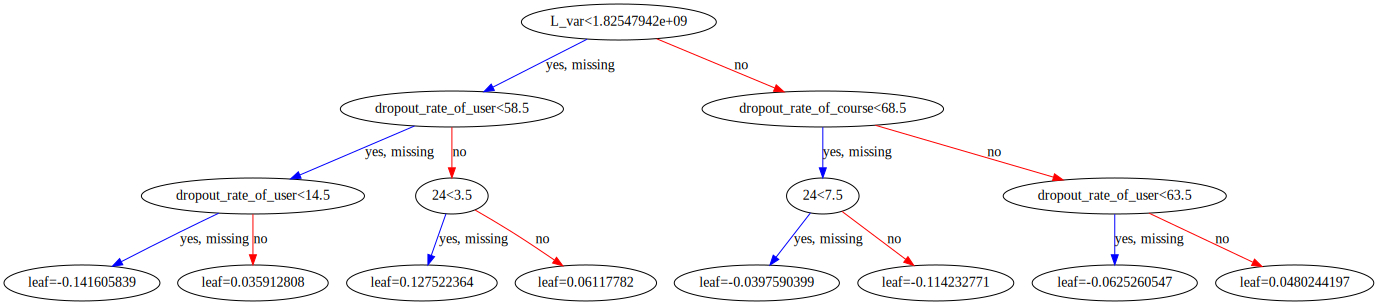

In [34]:
fig.set_size_inches(60,30)
xgb.to_graphviz(XGB_df_md3)

In [35]:
def xgb_model_depth_2(train_data,test_data)->list:

    dtrain = xgb.DMatrix(train_data, list_label_train)
    dtest = xgb.DMatrix(test_data,list_label_test)
    num_rounds = 10
    params = {'max_depth':2}
    watchlist = [(dtrain,'train'),(dtest,'test')]
    XGB_nom = xgb.train(
        
        params, 
        dtrain, 
        num_rounds,
        watchlist,
        early_stopping_rounds=10) 
        
    #import pickle
    #pickle.dump(XGB_nom, open("XGB_simple_no_nom_f1_9015.pickle.dat", "wb"))

    XGB_predict_label = XGB_nom.predict(dtest)
    plot_AUC(list_label_test,XGB_predict_label)
    for i in [0.1,0.2,0.3,0.4,0.5,0.6]:
            
        XGB_predict_label_int = predict_label_to_int(XGB_predict_label,threshold=i)
        #print('XGB ',i,' : ')
        measure(
                XGB_predict_label_int,list_label_test)
    
    return XGB_nom

[0]	train-rmse:0.43417	test-rmse:0.43591
[1]	train-rmse:0.39367	test-rmse:0.39790
[2]	train-rmse:0.36926	test-rmse:0.37690
[3]	train-rmse:0.35494	test-rmse:0.36546
[4]	train-rmse:0.34598	test-rmse:0.35809
[5]	train-rmse:0.34067	test-rmse:0.35412
[6]	train-rmse:0.33675	test-rmse:0.35170
[7]	train-rmse:0.33414	test-rmse:0.35005
[8]	train-rmse:0.33241	test-rmse:0.34927
[9]	train-rmse:0.33108	test-rmse:0.34855


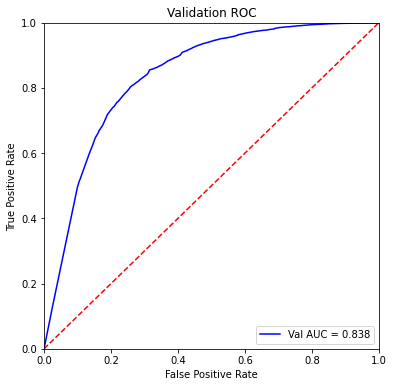

F1 0.8641 precision 1.0 recall 0.76 ACC 0.76
F1 0.8835 precision 0.99 recall 0.8 ACC 0.8
F1 0.8904 precision 0.99 recall 0.81 ACC 0.82
F1 0.8958 precision 0.97 recall 0.83 ACC 0.83
F1 0.897 precision 0.95 recall 0.85 ACC 0.83
F1 0.8928 precision 0.92 recall 0.87 ACC 0.83


In [36]:

XGB_df_md2=xgb_model_depth_2(pd.DataFrame(train_data_simple_padding,columns = col),pd.DataFrame(test_data_simple_padding,columns = col))


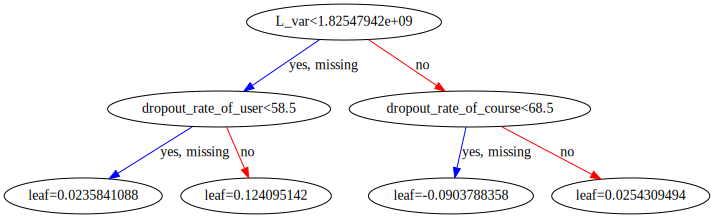

In [37]:
fig.set_size_inches(60,30)
xgb.to_graphviz(XGB_df_md2)

In [38]:
1/float(1+np.exp(0.0235841088))

0.4941042460706667

In [39]:
1/float(1+np.exp(0.124095142))

0.4690159661201664

In [40]:
1/float(1+np.exp(-0.0903788358))

0.5225793414085619

In [41]:
1/float(1+np.exp(0.0254309494))

0.49364260527448633

In [42]:
def xgb_model_depth_2(train_data,test_data)->list:

    dtrain = xgb.DMatrix(train_data, list_label_train)
    dtest = xgb.DMatrix(test_data,list_label_test)
    num_rounds = 10
    params = {
        'objective': 'binary:logistic', 
        'max_depth':2}
    watchlist = [(dtrain,'train'),(dtest,'test')]
    XGB_nom = xgb.train(
        
        params, 
        dtrain, 
        num_rounds,
        watchlist,
        early_stopping_rounds=10) 
        
    #import pickle
    #pickle.dump(XGB_nom, open("XGB_simple_no_nom_f1_9015.pickle.dat", "wb"))

    XGB_predict_label = XGB_nom.predict(dtest)
    plot_AUC(list_label_test,XGB_predict_label)
    for i in [0.46,0.47,0.48,0.49,0.5,0.51,0.52]:
            
        XGB_predict_label_int = predict_label_to_int(XGB_predict_label,threshold=i)
        #print('XGB ',i,' : ')
        measure(
                XGB_predict_label_int,list_label_test)
    
    return XGB_nom

[23:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.56993	test-logloss:0.57293
[1]	train-logloss:0.49840	test-logloss:0.50521
[2]	train-logloss:0.45391	test-logloss:0.46615
[3]	train-logloss:0.42439	test-logloss:0.44074
[4]	train-logloss:0.40386	test-logloss:0.42286
[5]	train-logloss:0.39085	test-logloss:0.41138
[6]	train-logloss:0.38196	test-logloss:0.40302
[7]	train-logloss:0.37353	test-logloss:0.40190
[8]	train-logloss:0.36830	test-logloss:0.39781
[9]	train-logloss:0.36361	test-logloss:0.39438


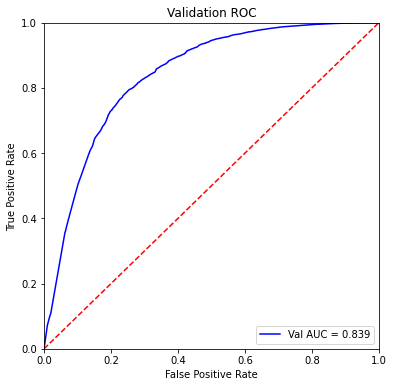

F1 0.8982 precision 0.96 recall 0.84 ACC 0.83
F1 0.8976 precision 0.96 recall 0.85 ACC 0.83
F1 0.8978 precision 0.96 recall 0.85 ACC 0.84
F1 0.8982 precision 0.95 recall 0.85 ACC 0.84
F1 0.8985 precision 0.95 recall 0.85 ACC 0.84
F1 0.8982 precision 0.95 recall 0.85 ACC 0.84
F1 0.8981 precision 0.95 recall 0.86 ACC 0.84


In [43]:

XGB_df_md2=xgb_model_depth_2(pd.DataFrame(train_data_simple_padding,columns = col),pd.DataFrame(test_data_simple_padding,columns = col))
